In [1]:
import io
import os
import time
from datetime import datetime
from pathlib import Path
from typing import Iterable

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")

In [3]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

tools_list = [
    {"type": "code_interpreter"},
]

In [4]:
DATA_FOLDER = "./data/energy/"


def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")


arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath = DATA_FOLDER + file
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

In [5]:
assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    instructions="You are an assistant that can help manage wind turbine farm. "
    + "The turbines operating ranges are output voltages of 33kv-35kv and RPM of 15-25. Wind speed is measured in miles per hour."
    + "Maintenance should occur every 12 months. Greet the user by saying, 'Welcome Turbine Management Assistant.'",
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)

thread = client.beta.threads.create()

In [6]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image
                image.show()

In [7]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + ". ",
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed" or run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        if run.status == "expired":
            # Handle expired
            break
        if run.status == "cancelled":
            # Handle cancelled
            break
        if run.status == "requires_action":
            pass
        else:
            # print("in progress...",run.status)
            time.sleep(5)

In [8]:
process_message("What is the status of turbine 1001 and 1003?")

processing...
user:
What is the status of turbine 1001 and 1003?

assistant:
To check the status of turbines 1001 and 1003, I'll need to inspect the contents of the file you uploaded. I'll start by opening the file and looking for relevant information related to turbine statuses.

Let's start by examining the contents of the file to find the information we need.

assistant:
It seems that the uploaded file does not have an extension, which makes it difficult to determine its format directly. To garner more information about the file, I will try opening it as a text file first, which is a common approach when dealing with unknown files. If the file isn't a text file, I will attempt other methods to establish its format. Let's proceed with the text-based analysis.

assistant:
The contents of the file appear to be in CSV format, with the following headers: `Turbine_ID`, `Wind_Speed`, `RPM`, `Voltage`, and `Maintenance_Date`. Each line corresponds to a record of a particular turbine.

I wil

processing...
user:
Generate a chart of the normal operating ranges?

assistant:
To create a chart of the normal operating ranges for the turbines in the dataset, we first need to determine what the normal operating ranges are for each parameter (Wind Speed, RPM, Voltage). Typically, these ranges are specified by the turbine manufacturer or determined from historical performance data where it is observed when turbines are operating normally.

Since we don't have the manufacturer's specifications or a specific definition of "normal" operating ranges within the provided dataset, we can infer a basic normal range by looking at the 25th and 75th percentiles (interquartile range, IQR) for Wind Speed, RPM, and Voltage. These percentiles give us a sense of the middle 50% of the data, which could be construed as a normal range in a general sense.

Let's calculate these percentiles and create a chart reflecting the normal operating ranges for Wind Speed, RPM, and Voltage.



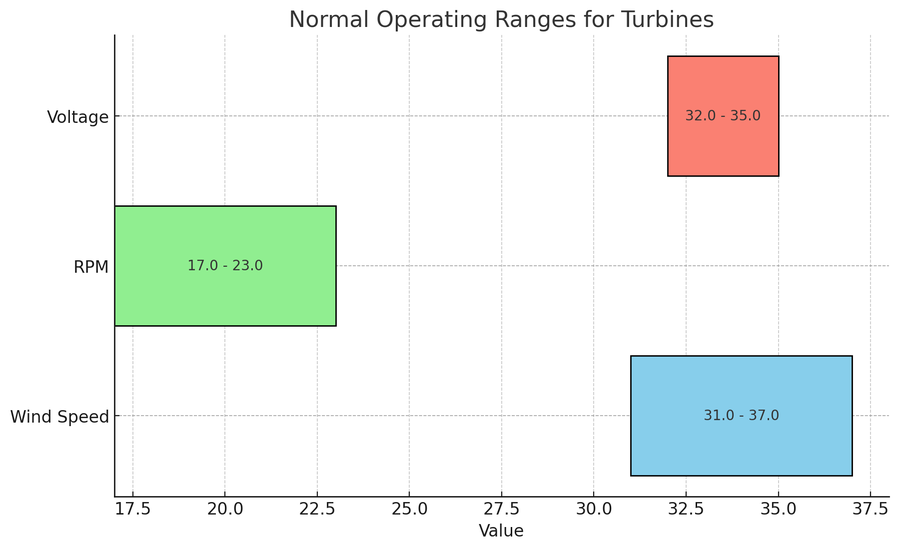

assistant:
The chart above represents the normal operating ranges for Wind Speed, RPM, and Voltage based on the interquartile range (IQR) from the dataset. The bars indicate the range between the 25th and 75th percentiles for each parameter:

- Wind Speed: The normal operating range depicted by the sky blue bar.
- RPM (Revolutions Per Minute): The normal operating range depicted by the light green bar.
- Voltage: The normal operating range depicted by the salmon-colored bar.

These ranges are inferred from the dataset and represent the middle 50% of the values, which could be considered as a normal operational range in a general context.



In [9]:
process_message("Generate a chart of the normal operating ranges?")

In [10]:
process_message(
    "What turbines are operating outside normal ranges?\n\n"
    + 'Sample: [{"turbine":"","voltage":30,"RPM":15,"reason":"Voltage outside of normal range."},\n'
    + '{"turbine":"","voltage":30,"rpm":10,"reason":"RPM and Voltage outside of normal ranges."},\n'
    + '{"turbine":"","voltage":33,"rpm":5,"reason":"RPM outside of normal range."}]\n\n'
    + 'Output format: [{"turbine":"","voltage":0,"RPM":0,"reason":""}]\n\n'
    + "Output in JSON format only."
)

processing...
user:
What turbines are operating outside normal ranges?

Sample: [{"turbine":"","voltage":30,"RPM":15,"reason":"Voltage outside of normal range."},
{"turbine":"","voltage":30,"rpm":10,"reason":"RPM and Voltage outside of normal ranges."},
{"turbine":"","voltage":33,"rpm":5,"reason":"RPM outside of normal range."}]

Output format: [{"turbine":"","voltage":0,"RPM":0,"reason":""}]

Output in JSON format only.

assistant:
Here is the list of turbines operating outside their normal ranges in JSON format:

```json
[
  {
    "turbine": "1003",
    "voltage": 32,
    "RPM": 16,
    "reason": "RPM outside of normal range."
  },
  {
    "turbine": "1004",
    "voltage": 36,
    "RPM": 24,
    "reason": "Voltage and RPM outside of normal range."
  },
  {
    "turbine": "1005",
    "voltage": 31,
    "RPM": 14,
    "reason": "Voltage and RPM outside of normal range."
  },
  {
    "turbine": "1009",
    "voltage": 32,
    "RPM": 15,
    "reason": "RPM outside of normal range."
  },
 

In [11]:
process_message("What turbines need maintenance?")

processing...
user:
What turbines need maintenance?

assistant:
All turbines with the following IDs need maintenance as their maintenance date is earlier than the current date:

1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020

It appears that all turbines listed in the dataset require maintenance based on their scheduled maintenance dates.



In [12]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)
for file in assistant_files:
    client.files.delete(file.id)